In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os 
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

import settings as s
import Hearis as h
from Custom import Mouse

import scipy.io as sio
    
batch = s.Batch()

#water_path = '/home/anverdie/Documents/Code/MFB_Paper/Water'
#mfb_path = '/home/anverdie/Documents/Code/MFB_Paper/MFB'

water_path = '/home/pouple/PhD/Code/MFB_Paper/Water'
mfb_path = '/home/pouple/PhD/Code/MFB_Paper/MFB'

plt.style.use('fivethirtyeight')

In [2]:
class MouseMFB(object):
    def __init__(self, path, verbose=True, rmgaps=False):
        self.verbose = verbose
        self.path = path
        data = self.__load_data(self.path)
        self.day = data['Day'][0]
        self.corr = data['Correct'][0]
        self.idsound = data['SoundId'][0]
        self.idtrial = data['TrialId'][0]
        self.rule = data['Rule'][0]
        self.WeekDay = data['DayOfWeek'][0]
        self.ForkAct = data['ForkAct'][0]
        
        self.compute_fork()
        if rmgaps == 'Antonin':
            self.rmgaps_antonin()
        elif rmgaps == 'Brice':
            self.rmgaps_brice()
        
        self.split_in_sessions()
        
        if self.verbose: print('Mouse', os.path.basename(self.path)[1:-4], 'Loaded')
    
    def __load_data(self, path):
        return sio.loadmat(path)
    
    def compute_fork(self):
        # Need to do sanity check 
        ta_type = np.where(self.idtrial == 0 | 2, 0, self.idtrial) 
        self.fork = np.multiply(np.logical_not(np.logical_xor(ta_type, self.corr)), 1)

    def rmgaps_antonin(self):
        str_fork = [str(f) for f in self.fork]
        str_fork = ''.join(str_fork)
        no_licks = [[m.start(), m.end() - 1] for m in re.finditer('[0]+', str_fork) if m.end() - m.start() > 15]        
        print(no_licks)
        for gap in reversed(no_licks):
            self.corr = np.delete(self.corr, np.arange(gap[0], gap[1]))
            self.idtrial = np.delete(self.idtrial, np.arange(gap[0], gap[1]))
            self.idsound = np.delete(self.idsound, np.arange(gap[0], gap[1]))
            self.WeekDay = np.delete(self.WeekDay, np.arange(gap[0], gap[1]))
            self.day = np.delete(self.day, np.arange(gap[0], gap[1]))

    def rmgaps_brice(self):
        
        go_idx = [i for i, g in enumerate(self.idtrial) if g == 1]
        go_corr = [int(self.corr[i]) for i in go_idx]
        
        str_gos = [str(i) for i in go_corr]
        str_gos = ''.join(str_gos)
        no_licks = [[m.start(), m.end() - 1] for m in re.finditer('[0]+', str_gos) if m.end() - m.start() > 5]        
        print(no_licks)
        for gap in reversed(no_licks):
            self.corr = np.delete(self.corr, np.arange(gap[0], gap[1]))
            self.idtrial = np.delete(self.idtrial, np.arange(gap[0], gap[1]))
            self.idsound = np.delete(self.idsound, np.arange(gap[0], gap[1]))
            self.WeekDay = np.delete(self.WeekDay, np.arange(gap[0], gap[1]))
            self.day = np.delete(self.day, np.arange(gap[0], gap[1]))
    
    def split_in_sessions(self):
        self.corrs = []
        self.idsounds = []
        self.idtrials = []
        self.forks = []
        for day in np.unique(self.day):
            indices = np.where(self.day == day)
            self.corrs.append(self.corr[indices])
            self.idsounds.append(self.idsound[indices])
            self.idtrials.append(self.idtrial[indices])
            self.forks.append(self.fork[indices])
    
    def get_session_score(self):
        scores = [np.sum(corr)*100/len(corr) for corr in self.corrs]
        return scores
    
    def get_best_sessions_scores(self, n_sess):
        best_sess = np.argsort(self.get_session_score())[-n_sess:]
        return best_sess
    def keep_best_sessions(self, n_sess):
        best_sess = self.get_best_sessions_scores(n_sess)
        self.best_corrs = list(np.array(self.corrs, dtype=object)[best_sess])
        self.best_idsounds = list(np.array(self.idsounds, dtype=object)[best_sess])
        self.best_idtrials = list(np.array(self.idtrials, dtype=object)[best_sess])
        self.best_forks = list(np.array(self.forks, dtype=object)[best_sess])

In [13]:
# Paths for MFB data
# Paths for Water Data
def load_water(batch3=False, tag='PC', rmgaps=False, verbose=True, rmblocks=None, linkday=None):
    mice_id = batch.id_first_batch
    if batch3: mice_id = batch.id_third_batch
    mice_water = [Mouse(path=os.path.join(water_path, f), tag=[tag], linkday=linkday, collab=False, rmgaps=rmgaps, verbose=verbose, rmblocks=rmblocks) for f in mice_id]
    
    return mice_water 

def load_MFB(tag='PC', verbose=False, rmgaps=False):
    # Load MFB mice data
    if tag =='PC': path = os.path.join(mfb_path, 'Psychophysics_MFB')
    elif tag =='DIS': path = os.path.join(mfb_path, 'GoVsNoGo_MFB')
    elif tag =='DISC': path = os.path.join(mfb_path, 'GoVsNoGo_ChirpStepLev1_MFB')
    elif tag =='DISC2': path = os.path.join(mfb_path, 'GoVsNoGo_ChirpStepLev2_MFB')

    mice_mfb = os.listdir(path)
    paths = [os.path.join(path, f) for f in os.listdir(path)]
    mice_mfb = [MouseMFB(path, verbose, rmgaps) for path in paths]
    
    return mice_mfb

In [4]:
mice_water_dis = load_water(batch3=True, verbose=False, tag='DIS',rmgaps='Brice')
mice_mfb_dis = load_MFB(tag='DIS', verbose=False, rmgaps='Brice')

[[29, 35]]
[]
[[338, 348], [360, 365], [368, 374], [414, 424], [426, 434], [440, 445], [474, 483], [493, 499], [502, 508], [548, 574], [1072, 1079], [1105, 1112], [1114, 1133], [1160, 1170], [1191, 1215], [1315, 1322], [1324, 1332]]
[[19, 24], [70, 82], [554, 615]]
[[403, 415], [948, 953], [1193, 1202]]
[[177, 183], [190, 198]]
[[0, 6]]
[[246, 259]]


In [5]:
mice_water_pc = load_water(batch3=False, verbose=False, tag='PC', rmgaps='Brice')
mice_mfb_pc = load_MFB(tag='PC', verbose=False, rmgaps='Brice')

[[437, 456], [458, 464], [466, 474], [650, 661], [2451, 2457], [3895, 3900], [4217, 4223], [4277, 4283], [4342, 4347], [4354, 4361]]
[[159, 164], [167, 185], [199, 217], [346, 352], [357, 369], [371, 379], [717, 722], [726, 744], [791, 798], [807, 818], [827, 844], [859, 879], [890, 906], [923, 931], [1010, 1017], [1020, 1042], [1055, 1066], [1068, 1103], [1475, 1499], [1506, 1539], [1591, 1599], [2749, 2754], [2790, 2796], [2808, 2815], [2819, 2851], [3008, 3013], [3158, 3165]]
[[2189, 2196], [2240, 2251], [2253, 2261], [2287, 2295], [2299, 2305], [2307, 2326], [2390, 2397], [2561, 2569], [2622, 2639], [2641, 2655], [2657, 2670]]
[[84, 96], [115, 133], [295, 303], [314, 319], [937, 945]]
[[165, 171], [3731, 3736]]
[[398, 406], [1152, 1159], [2439, 2444], [2451, 2457]]
[[86, 91], [689, 700], [703, 708], [716, 726], [728, 741], [900, 908], [911, 916], [940, 949], [957, 969], [1018, 1026], [1065, 1076], [1163, 1168], [1288, 1298], [2889, 2907]]
[[381, 390], [572, 585]]


In [6]:
mice_water_disc = load_water(batch3=True, verbose=False, tag='DISC', rmgaps='Brice')
mice_mfb_disc = load_MFB(tag='DISC', verbose=False, rmgaps='Brice')

[[41, 53], [68, 75], [80, 90], [94, 99], [951, 956], [976, 987], [990, 1000], [1113, 1120], [1474, 1481], [1586, 1592], [3378, 3383]]
[]
[]
[[11, 31], [43, 51], [307, 314]]


# Learning Figure
- Boxplot 1er jour / 1er ensemble de trials supérieur à 80%
    - Ranksum
    - DIS, PC et DISC
    - Display points

0.09333754717802296
0.024027671425442047
0.10819724752370144


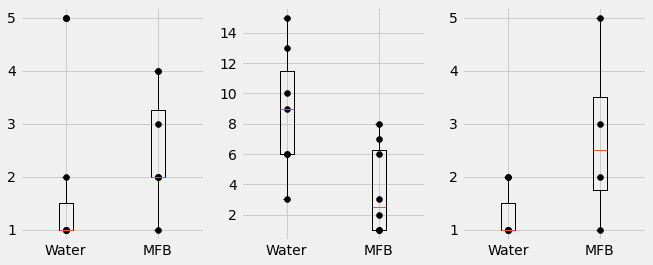

In [7]:
# Need to add ranksum still
# Maybe add jitter on points
from scipy.stats import ranksums

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

####################################### DIS ###########################################
scores_water = [mouse.perf() for mouse in mice_water_dis]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_dis]

# Water
dates = []
for i, m in enumerate(scores_water):
    dates.append([(d - m[1]).astype('timedelta64[D]') + 1 for d in m[1:]])
scores_water = [np.array(s[0]) for s in scores_water]
first_day_over80_water = [np.where(s >= 70)[0][0] + 1 for s in scores_water]

# MFB
first_day_over80_mfb = [np.where(np.array(s) >= 70)[0][0] + 1 for s in scores_mfb]

stdis, pdis = ranksums(first_day_over80_water, first_day_over80_mfb)
print(pdis)
axs[0].boxplot([first_day_over80_water, first_day_over80_mfb], vert=True)
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Water', 'MFB'])
axs[0].scatter([1]*len(first_day_over80_water), first_day_over80_water, c='black')
axs[0].scatter([2]*len(first_day_over80_mfb), first_day_over80_mfb, c='black')

####################################### PC ###########################################
scores_water = [mouse.perf() for mouse in mice_water_pc]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_pc]

# Water
dates = []
for i, m in enumerate(scores_water):
    dates.append([(d - m[1]).astype('timedelta64[D]') + 1 for d in m[1:]])
scores_water = [np.array(s[0]) for s in scores_water]
first_day_over80_water = [np.where(s >= 80)[0][0] + 1 for s in scores_water]

# MFB
first_day_over80_mfb = [np.where(np.array(s) >= 80)[0][0] + 1 for s in scores_mfb]

stpc, ppc = ranksums(first_day_over80_water, first_day_over80_mfb)
print(ppc)
axs[1].boxplot([first_day_over80_water, first_day_over80_mfb], vert=True)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Water', 'MFB'])
axs[1].scatter([1]*len(first_day_over80_water), first_day_over80_water, c='black')
axs[1].scatter([2]*len(first_day_over80_mfb), first_day_over80_mfb, c='black')

####################################### DISC ###########################################
scores_water = [mouse.perf() for mouse in mice_water_disc]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_disc]

# Water
dates = []
for i, m in enumerate(scores_water):
    dates.append([(d - m[1]).astype('timedelta64[D]') + 1 for d in m[1:]])
scores_water = [np.array(s[0]) for s in scores_water]
first_day_over80_water = [np.where(s >= 60)[0][0] + 1 for s in scores_water]

# MFB####################################### DIS ###########################################

first_day_over80_mfb = [np.where(np.array(s) >= 60)[0][0] + 1 for s in scores_mfb]

stdisc, pdisc = ranksums(first_day_over80_water, first_day_over80_mfb)
print(pdisc)
axs[2].boxplot([first_day_over80_water, first_day_over80_mfb], vert=True)
axs[2].set_xticks([1, 2])
axs[2].set_xticklabels(['Water', 'MFB'])
axs[2].scatter([1]*len(first_day_over80_water), first_day_over80_water, c='black')
axs[2].scatter([2]*len(first_day_over80_mfb), first_day_over80_mfb, c='black')

plt.show()

# Learning curves
Courbe apprentissage pour DIS, PC et DISC. Moyenne avec dernière valeure

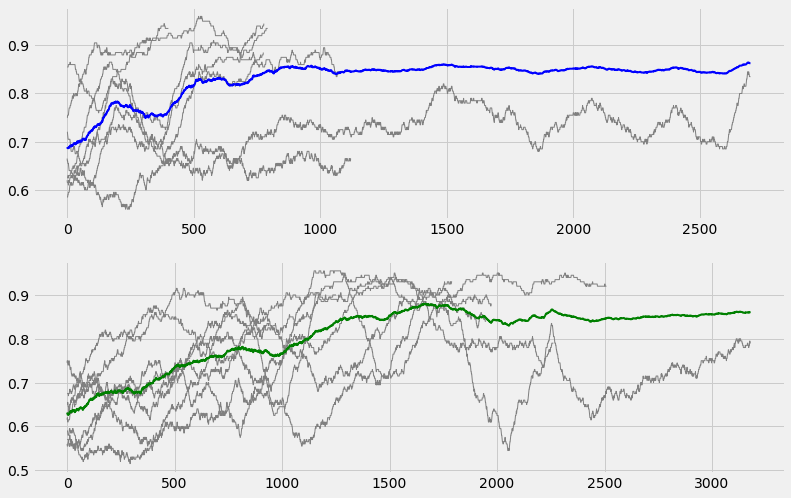

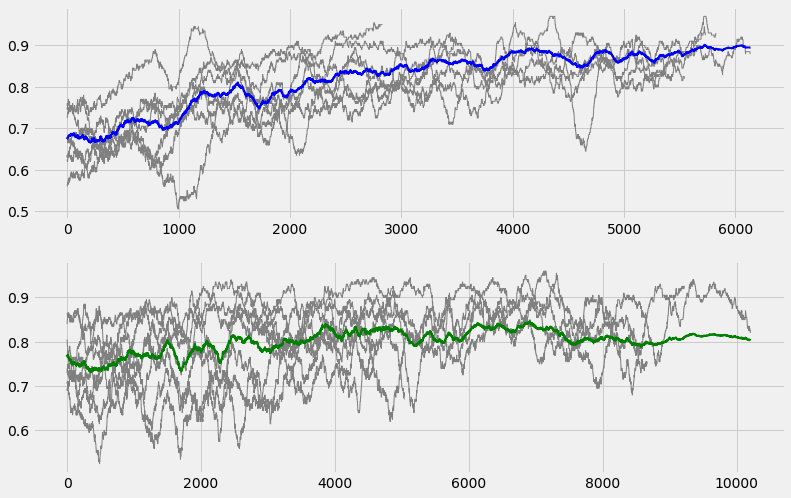

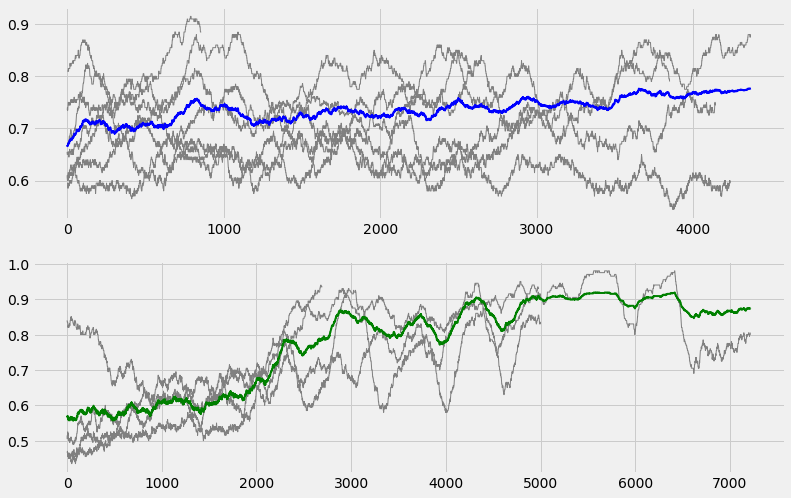

In [8]:
smoothness = 200

####################################### DIS ###########################################
fig, axs = plt.subplots(2, figsize=(12, 8))

all_convo_water = []
for mouse in mice_water_dis:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    all_convo_water.append(convo_water)
    axs[0].plot(convo_water, color='grey', linewidth=1)

longest_mouse = np.max([len(c) for c in all_convo_water])
all_convo_water= np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_water])
axs[0].plot(np.mean(all_convo_water, axis=0), c='blue', linewidth=2)

all_convo_mfb = []
for mouse in mice_mfb_dis:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo_mfb, color='grey', linewidth=1)
    all_convo_mfb.append(convo_mfb)

longest_mouse = np.max([len(c) for c in all_convo_mfb])
all_convo_mfb = np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_mfb])
axs[1].plot(np.mean(all_convo_mfb, axis=0), c='green', linewidth=2)

plt.show()

####################################### PC ###########################################
fig, axs = plt.subplots(2, figsize=(12, 8))

all_convo_water = []
for mouse in mice_water_pc:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    all_convo_water.append(convo_water)
    axs[0].plot(convo_water, color='grey', linewidth=1)

longest_mouse = np.max([len(c) for c in all_convo_water])
all_convo_water= np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_water])
axs[0].plot(np.mean(all_convo_water, axis=0), c='blue', linewidth=2)

all_convo_mfb = []
for mouse in mice_mfb_pc:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo_mfb, color='grey', linewidth=1)
    all_convo_mfb.append(convo_mfb)

longest_mouse = np.max([len(c) for c in all_convo_mfb])
all_convo_mfb = np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_mfb])
axs[1].plot(np.mean(all_convo_mfb, axis=0), c='green', linewidth=2)
plt.show()

####################################### DISC ###########################################
fig, axs = plt.subplots(2, figsize=(12, 8))
all_convo_water = []
for mouse in mice_water_disc:
    files = mouse.elphy
    tasks = np.concatenate([f.tr_corr for f in files])
    convo_water = np.convolve(tasks, np.ones(smoothness)/smoothness, mode='valid')
    all_convo_water.append(convo_water)
    axs[0].plot(convo_water, color='grey', linewidth=1)

longest_mouse = np.max([len(c) for c in all_convo_water])
all_convo_water= np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_water])
axs[0].plot(np.mean(all_convo_water, axis=0), c='blue', linewidth=2)

all_convo_mfb = []
for mouse in mice_mfb_disc:
    all_corrs = np.concatenate(mouse.corrs)
    convo_mfb = np.convolve(all_corrs, np.ones(smoothness)/smoothness, mode='valid')
    axs[1].plot(convo_mfb, color='grey', linewidth=1)
    all_convo_mfb.append(convo_mfb)

longest_mouse = np.max([len(c) for c in all_convo_mfb])
all_convo_mfb = np.array([np.pad(c, (0, longest_mouse - len(c)), mode='edge') for c in all_convo_mfb])
axs[1].plot(np.mean(all_convo_mfb, axis=0), c='green', linewidth=2)
plt.show()

# Learning
- Psycoacoustic with error bars


In [9]:
mice_water_pc = load_water(batch3=False, verbose=False, tag='PC', rmgaps=True)
mice_mfb_pc = load_MFB(tag='PC', verbose=False)
for mouse in mice_water_pc: mouse.select_best_trials(3)
for mouse in mice_mfb_pc: mouse.keep_best_sessions(3)

Best scores are : [90.     90.3125 90.625 ]
Best scores are : [84.375  85.625  89.0625]
Best scores are : [91.875 92.5   94.375]
Best scores are : [90.3125 91.5625 92.5   ]
Best scores are : [87.1875 89.375  89.375 ]
Best scores are : [86.875 87.5   91.25 ]
Best scores are : [84.6875 85.9375 91.25  ]


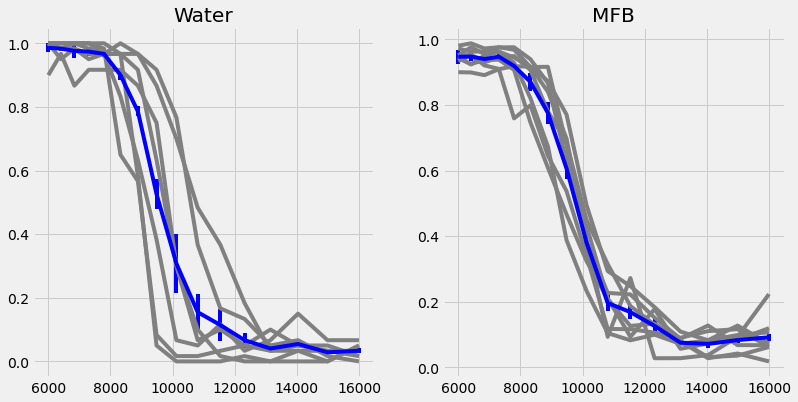

In [10]:
probs = np.array([mouse.psychoacoustic(plot=False)[1] for mouse in mice_water_pc])
probs_reversed = np.array([np.flip(p) if mice_water_pc[i].reversed else p for i, p in enumerate(probs)])
sem_water = np.std(probs_reversed, axis=0) / np.sqrt(probs_reversed.shape[0])
reverse = [mouse.reversed for mouse in mice_water_pc]
probs = [np.abs(1-p) if reverse[i] else p for i, p in enumerate(probs)]

psycos_mfb = np.empty((len(mice_mfb_pc), 16))
for i, mouse in enumerate(mice_mfb_pc):
    all_trailsid = np.concatenate(mouse.best_idtrials)
    all_corr = np.concatenate(mouse.best_corrs)
    all_taskid = np.concatenate(mouse.best_idsounds)
    
    psycho = np.array([c if all_trailsid[i] == 1 else not(c) for i, c in enumerate(all_corr)]) 
    
    scores = np.empty((16,))
    for j, t in enumerate(np.sort(np.unique(all_taskid))):
        idxs = np.where(all_taskid == t)[0]
        curr_corr = psycho[idxs]
        score = np.sum(curr_corr)/len(curr_corr)
        scores[j] = score
    psycos_mfb[i] = scores    

    
probs_mfb_reverse = [np.flip(p) if mice_mfb_pc[i].rule == 'H' else p for i, p in enumerate(psycos_mfb)]
psycos_mfb = [np.abs(1 - s) if mice_mfb_pc[i].rule == 'H' else s for i, s in enumerate(psycos_mfb)]    

probs_mfb_reverse = np.array(probs_mfb_reverse)
sem_mfb = np.std(probs_mfb_reverse, axis=0) / np.sqrt(probs_mfb_reverse.shape[0]) 
psycos_mfb = np.array(psycos_mfb)      
        
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scale = np.geomspace(6e3, 16e3, 16)
for p in probs:
    axs[0].plot(scale, p, c='gray')
axs[0].errorbar(scale, np.mean(probs, axis=0), yerr=sem_water, c='blue')
axs[0].set_title('Water')


for p in psycos_mfb:
    axs[1].plot(scale, p, c='gray')
axs[1].errorbar(scale, np.mean(psycos_mfb, axis=0), yerr=sem_mfb, c='blue')
axs[1].set_title('MFB')

plt.show()

[320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320]
[1277, 958, 1756, 1500, 1425, 958, 797, 1437, 488, 479, 2075, 1152, 573, 477, 701, 1179, 1450, 1915, 709, 670, 1436, 797, 478, 475, 479, 958, 1374, 2236, 319, 638, 1756, 1167, 1877, 382, 1593, 1466]


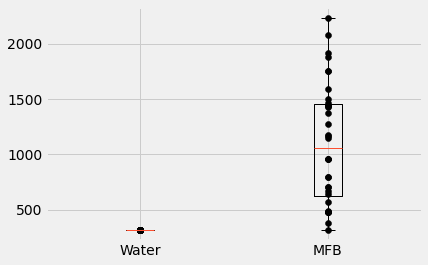

In [54]:
# Get best longest sessions in both methods
scores_water = [mouse.perf()[0] for mouse in mice_water_pc]
scores_mfb = [[np.sum(c)*100/len(c) for c in mouse.corrs] for mouse in mice_mfb_pc]

distrib = []
for i, m in enumerate(scores_water):
    for j, sess in enumerate(m):
        if sess > 80:
            distrib.append(len(mice_water_pc[i].elphy[j].tr_corr))

distrib_mfb = []
for i, m in enumerate(scores_mfb):
    for j, sess in enumerate(m):
        if sess > 80:
            distrib_mfb.append(len(mice_mfb_pc[i].corrs[j]))
print(distrib)
print(distrib_mfb)

plt.boxplot([distrib, distrib_mfb], vert=True)
plt.xticks([1, 2], labels=['Water', 'MFB'])
plt.scatter([1]*len(distrib), distrib, c='black')
plt.scatter([2]*len(distrib_mfb), distrib_mfb, c='black')
plt.show()

In [26]:
mice_water_pc = load_water(batch3=False, verbose=False, tag='PC', rmgaps=True, linkday=True)
mice_mfb_pc = load_MFB(tag='PC', verbose=False)

[240, 240, 240, 240, 240, 320, 320, 320, 320, 320, 320, 320, 320]
[240, 240, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320]
[240, 240, 320, 320, 320, 320, 320, 320, 320, 320]
[240, 240, 240, 240, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320]
[240, 240, 240, 240, 240, 320, 320, 320, 320, 320, 320, 320, 423, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320]
[240, 240, 240, 240, 240, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320]
[240, 240, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320]
